# **Importing dataset and preprocessing**

In [1]:
import pandas as pd
from matplotlib import pyplot as plt 

In [2]:
positive_polarity_dataset_path = '/kaggle/input/polarity-data/rt-polarity.pos'
negative_polarity_dataset_path = '/kaggle/input/polarity-data/rt-polarity.neg'

In [3]:
[1] * 5

[1, 1, 1, 1, 1]

In [4]:
def read_dataset(dataset_path: str, label: int) -> pd.DataFrame:
    
    line_dict = {
        'sentence': [],
        'label': []
    }
    
    with open(dataset_path, 'r', encoding='latin-1') as f:
        
        for line in f:
            line = line.strip()
            if line == '':
                continue
            line_dict['sentence'].append(line)
        line_dict['label'] = [label] * len(line_dict['sentence']) 
        
    dataset = pd.DataFrame(line_dict)
    return dataset

In [5]:
positive_polarity_dataset = read_dataset(positive_polarity_dataset_path, 1)
negative_polarity_dataset = read_dataset(negative_polarity_dataset_path, 0)

In [6]:
positive_polarity_dataset.shape

(5331, 2)

In [7]:
negative_polarity_dataset.shape

(5331, 2)

In [8]:
positive_polarity_dataset.dropna(inplace=True)
negative_polarity_dataset.dropna(inplace=True)

In [9]:
from nltk.tokenize import word_tokenize

In [10]:
positive_polarity_dataset.head()

,sentence,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [11]:
word_tokenize(positive_polarity_dataset['sentence'][0])

['the',
 'rock',
 'is',
 'destined',
 'to',
 'be',
 'the',
 '21st',
 'century',
 "'s",
 'new',
 '``',
 'conan',
 '``',
 'and',
 'that',
 'he',
 "'s",
 'going',
 'to',
 'make',
 'a',
 'splash',
 'even',
 'greater',
 'than',
 'arnold',
 'schwarzenegger',
 ',',
 'jean-claud',
 'van',
 'damme',
 'or',
 'steven',
 'segal',
 '.']

## Train Test Val Split

In [12]:
def train_test_split(positive_dataset: pd.DataFrame, negative_dataset: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    positive_dataset = positive_dataset.reset_index(drop=True)
    negative_dataset = negative_dataset.reset_index(drop=True)
    
    train_positive = positive_dataset[:4000]
    train_negative = negative_dataset[:4000]
    train_dataset = pd.concat([train_positive, train_negative], axis=0).reset_index(drop=True)
    
    val_positive = positive_dataset[4000:4500]
    val_negative = negative_dataset[4000:4500]
    val_dataset = pd.concat([val_positive, val_negative], axis=0).reset_index(drop=True)
    
    test_positive = positive_dataset[4500:]
    test_negative = negative_dataset[4500:]
    test_dataset = pd.concat([test_positive, test_negative], axis=0).reset_index(drop=True)
    
    train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)
    val_dataset = val_dataset.sample(frac=1).reset_index(drop=True)
    test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)
    
    return train_dataset, val_dataset, test_dataset

In [13]:
train_dataset, val_dataset, test_dataset = train_test_split(positive_polarity_dataset, negative_polarity_dataset)

In [14]:
print(f'Train dataset: {train_dataset.shape}')
print(f'Val dataset: {val_dataset.shape}')
print(f'Test dataset: {test_dataset.shape}')

Train dataset: (8000, 2)
Val dataset: (1000, 2)
Test dataset: (1662, 2)


## Dataset Classs

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
class PolarityDataset(Dataset):
    def __init__(self, dataset: pd.DataFrame, tokenizer):
        self.tokenizer = tokenizer
        
        self.sentences = list(dataset['sentence'])
        self.labels = list(dataset['label'])
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        tokenized_sentence = self.tokenizer(self.sentences[idx], padding='max_length', truncation=True, return_tensors='pt')
        
        return {
            'input_ids': tokenized_sentence['input_ids'],
            'attention_mask': tokenized_sentence['attention_mask'],
            'labels': torch.tensor(self.labels[idx])
        }

In [17]:
train_dataset = PolarityDataset(train_dataset, tokenizer)
val_dataset = PolarityDataset(val_dataset, tokenizer)
test_dataset = PolarityDataset(test_dataset, tokenizer)

In [18]:
train_dataset[:5]

{'input_ids': tensor([[ 101, 2348, 2009,  ...,    0,    0,    0],
         [ 101, 2009, 1005,  ...,    0,    0,    0],
         [ 101, 2472, 4080,  ...,    0,    0,    0],
         [ 101, 2472, 6927,  ...,    0,    0,    0],
         [ 101, 2025, 2144,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([1, 1, 1, 1, 1])}

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=3)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=3)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=3)

# **Creating the model**

In [20]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 20.9 MB/s eta 0:00:0000:01


In [21]:
import torch
import torch.nn as nn
import lightning as L
from torch.optim import Adam

In [22]:
class PolarityAnalyzer(L.LightningModule):
    def __init__(self, vocab_size, embed_dim, learning_rate=2e-4, betas=(0.5, 0.999), weight_decay=1e-5):
        super(PolarityAnalyzer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
        self.optimizer = Adam(self.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)
        self.criterion = nn.BCELoss()
        
        self.train_losses = []
        self.val_losses = []
        
    def forward(self, input_ids, attention_mask):
        
        if input_ids.dim() == 3 and input_ids.size(1) == 1:  # Check if input has shape [batch_size, 1, seq_length]
            input_ids = input_ids.squeeze(1)  # Remove the extra dimension
        if attention_mask.dim() == 3 and attention_mask.size(1) == 1:
            attention_mask = attention_mask.squeeze(1)
                
        x = self.embedding(input_ids)

        x = x.permute(1, 0, 2)
        
        attention_mask = attention_mask.float()
        attn_output, _ = self.attention(x, x, x, key_padding_mask=attention_mask)
        x = torch.mean(attn_output, dim=0)
        
        x = self.classifier(x)
        return x
    
    def configure_optimizers(self):
        return self.optimizer
    
    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, target = batch['input_ids'], batch['attention_mask'], batch['labels']
        output = self(input_ids, attention_mask)
        loss = self.criterion(output, target.unsqueeze(-1).float())
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        if self.global_step % 25 == 0:
            self.train_losses.append(loss.item())

        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, target = batch['input_ids'], batch['attention_mask'], batch['labels']
        output = self(input_ids, attention_mask)
        loss = self.criterion(output, target.unsqueeze(-1).float())
        
        # Append loss every 50 steps
        # if self.global_step % 25 == 0:
        self.val_losses.append(loss.item())  # Append (epoch, loss)
        
        self.log("val_loss", loss, prog_bar=True)
    
    def plot_losses(self):
        # Get the number of training and validation epochs
        train_epochs = range(len(self.train_losses))
        val_step_interval = len(self.train_losses) / len(self.val_losses)  # Calculate the interval ratio
        
        # Generate x-axis points for validation losses, scaled to match training epochs
        val_epochs = [i * val_step_interval for i in range(len(self.val_losses))]

        plt.figure(figsize=(10, 5))
        
        # Plot training loss (occurs every epoch)
        plt.plot(train_epochs, self.train_losses, label='Training Loss', color='blue')
        
        # Plot validation loss with scaled x-axis
        plt.plot(val_epochs, self.val_losses, label='Validation Loss', color='orange')
        
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [23]:
vocab_size = tokenizer.vocab_size
embed_dim = 768
learning_rate = 6e-5

In [24]:
model = PolarityAnalyzer(vocab_size, embed_dim, learning_rate)

## Trying a forward pass

In [25]:
a = train_dataset[:5]

In [26]:
len(train_dataset[0]['input_ids'][0])

512

In [27]:
a

{'input_ids': tensor([[ 101, 2348, 2009,  ...,    0,    0,    0],
         [ 101, 2009, 1005,  ...,    0,    0,    0],
         [ 101, 2472, 4080,  ...,    0,    0,    0],
         [ 101, 2472, 6927,  ...,    0,    0,    0],
         [ 101, 2025, 2144,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([1, 1, 1, 1, 1])}

In [28]:
model(a['input_ids'], a['attention_mask'])

tensor([[0.3800],
        [0.5504],
        [0.4628],
        [0.4990],
        [0.6872]], grad_fn=<SigmoidBackward0>)

# **Training the model**

In [29]:
trainer = L.Trainer(max_epochs=45)
trainer.fit(model, train_dataloader, val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | embedding  | Embedding          | 23.4 M | train
1 | attention  | MultiheadAttention | 2.4 M  | train
2 | classifier | Sequential         | 102 K  | train
3 | criterion  | BCELoss            | 0      | train
----------------------------------------------------------
25.9 M    Trainable params
0         Non-trainable params
25.9 M    Total params
103.625   Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=45` reached.


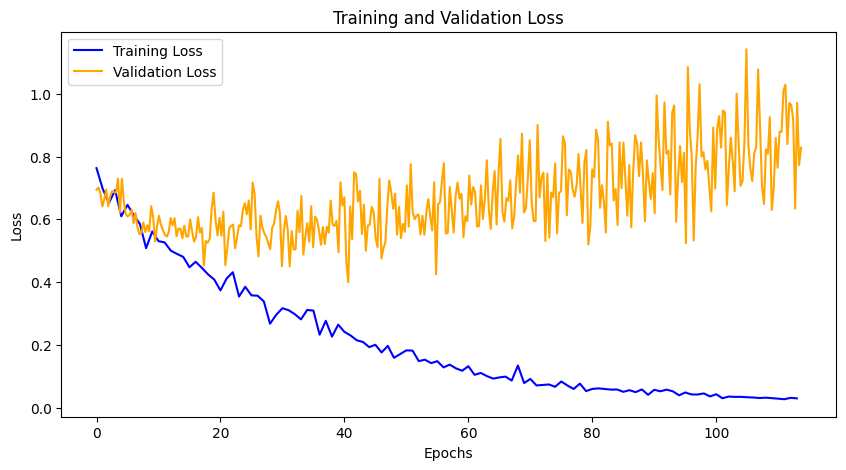

In [30]:
model.plot_losses()

# **Testing the model**

In [31]:
import numpy as np
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])

    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [32]:
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import json

def test_model(model, test_dataloader):
    model.eval()  # Set the model to evaluation mode
    all_outputs = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for testing
        for batch in tqdm(test_dataloader, desc="Testing"):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass
            outputs = model(input_ids, attention_mask)

            # Assuming outputs are logits; apply softmax or argmax as needed
            predictions = (outputs.clone().detach().squeeze() > 0.5).long()  # Convert to binary (0 or 1)

            # Collect outputs and labels
            all_outputs.append(predictions)
            all_labels.append(labels)

    # Concatenate all outputs and labels
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Calculate metrics using scikit-learn
    cm = confusion_matrix(all_labels, all_outputs)
    precision = precision_score(all_labels, all_outputs)
    recall = recall_score(all_labels, all_outputs)
    f1 = f1_score(all_labels, all_outputs)

    tn, fp, fn, tp = cm.ravel()

    # Create a metrics dictionary
    metrics = {
        "confusion_matrix": {
            "TP": tp.item(),
            "FP": fp.item(),
            "FN": fn.item(),
            "TN": tn.item()
        },
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    # Display metrics
    print(json.dumps(metrics, indent=4))

    # Plot confusion matrix
    plot_confusion_matrix(cm)

    return metrics  # Return the metrics in JSON format

Testing:   0%|          | 0/13 [00:00<?, ?it/s]

{
    "confusion_matrix": {
        "TP": 548,
        "FP": 195,
        "FN": 283,
        "TN": 636
    },
    "precision": 0.7375504710632571,
    "recall": 0.6594464500601684,
    "f1_score": 0.6963151207115629
}


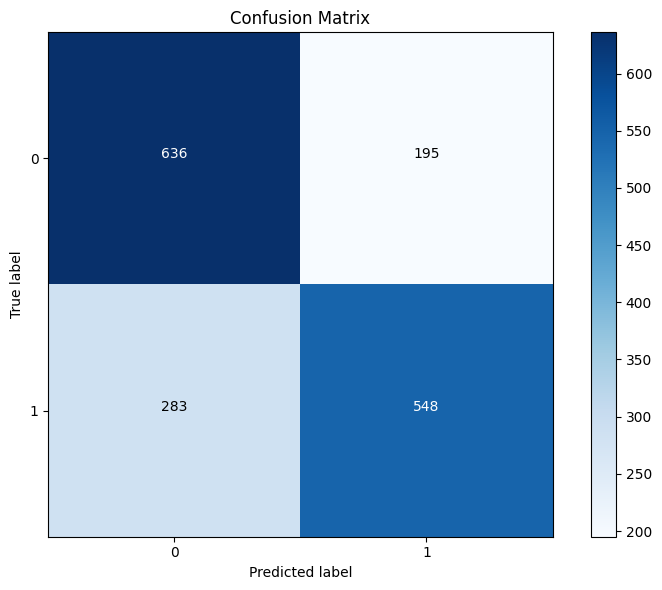

In [33]:
metrics = test_model(model, test_dataloader)

In [34]:
torch.save(model, 'model.pt')

# Load and predict function

Run the classes and other sections except trainer to properly load model

In [35]:
model_path = '/kaggle/working/model.pt'
model = torch.load(model_path)

/tmp/ipykernel_30/2288715837.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [36]:
def predict(sentences: list[str], tokenizer, model):
    tokenized_sentences = tokenizer(sentences, padding='max_length', truncation=True, return_tensors='pt')
    outputs = model(tokenized_sentences['input_ids'], tokenized_sentences['attention_mask'])
    
    predictions = (outputs.clone().detach().squeeze() > 0.5).long()  # Convert to binary (0 or 1)
    
    predicted_labels = ["positive" if pred == 1 else "negative" for pred in predictions]
    
    print(f"Sentences:")
    # Pretty print the sentences
    for i, sentence in enumerate(sentences, start=1):
        print(f"{i}. {sentence}")
    
    print()
    
    print(f"Prediction: {predicted_labels}")
    
    return predictions

In [37]:
sentences = [
    "The product exceeded my expectations and I absolutely love it!",
    "I am disappointed with the quality of this item.",
    "Service was great, but the food was mediocre.",
    "This is the best experience I've had in a long time!",
    "I would not recommend this to anyone.",
    "The team did an outstanding job delivering on time.",
    "I am unhappy with my purchase; it did not work as promised.",
    "What a fantastic movie! I enjoyed every minute of it.",
    "The service was slow, and the staff seemed uninterested.",
    "An incredible journey that I would happily repeat."
]

In [38]:
predictions = predict(sentences, tokenizer, model)

Sentences:
1. The product exceeded my expectations and I absolutely love it!
2. I am disappointed with the quality of this item.
3. Service was great, but the food was mediocre.
4. This is the best experience I've had in a long time!
5. I would not recommend this to anyone.
6. The team did an outstanding job delivering on time.
7. I am unhappy with my purchase; it did not work as promised.
8. What a fantastic movie! I enjoyed every minute of it.
9. The service was slow, and the staff seemed uninterested.
10. An incredible journey that I would happily repeat.

Prediction: ['negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive']
